In [1]:
import pandas as pd
import numpy as np

In [2]:
dup_df = pd.read_csv(r"Z:\elton\DI\duplicates.txt")
dup_df["frame"] += 1 

In [3]:
prev = dup_df.iloc[0,1] - 1
cont = 0

cont_list = np.zeros((1, dup_df.shape[0]))
bbox_matrix = np.zeros((dup_df.shape[0], 5))

for i in dup_df.index:
    path = f"M:\\experiment_70\\included\\{dup_df.iloc[i, 0]}\\supporting_files\\bbox_annotations_child_face\\img_{dup_df.iloc[i, 1]}.txt"

    try:
        bbox = np.loadtxt(path, delimiter=" ")
        bbox_matrix[i,:] = bbox[1:]
    except:
        pass


    if dup_df.iloc[i, 1] == prev + 1: 
        cont += 1 
        
    else:
        cont = 1 
    cont_list[0, i] = cont

    prev = dup_df.iloc[i, 1]

dup_df["cont"] = cont_list.T

C:\Users\multimaster\AppData\Local\Temp\ipykernel_59636\704322284.py:11: UserWarning: loadtxt: input contained no data: "M:\experiment_70\included\__20140610_16909\supporting_files\bbox_annotations_child_face\img_4328.txt"
  bbox = np.loadtxt(path, delimiter=" ")


In [4]:
dup_df["cont"].describe()

count    327.000000
mean       7.238532
std        6.357305
min        1.000000
25%        2.000000
50%        5.000000
75%       11.000000
max       26.000000
Name: cont, dtype: float64

In [5]:
temp = pd.DataFrame(bbox_matrix, columns=["xCenter","yCenter","w","h","conf"])
dup_df = pd.concat([dup_df, temp], axis=1)

In [6]:
dup_df["frame"] = dup_df["frame"].astype(int)
dup_df.head()

,subID,frame,cont,xCenter,yCenter,w,h,conf
0,__20141117_17062,1791,1.0,0.177498,0.794115,0.354996,0.409817,0.906869
1,__20141117_17062,1792,2.0,0.179790,0.814975,0.359581,0.368097,0.908439
2,__20141117_17062,2443,1.0,0.346097,0.294877,0.161710,0.316494,0.960901
3,__20141117_17062,2551,1.0,0.260287,0.761859,0.367764,0.474329,0.906285
4,__20141117_17062,2552,2.0,0.256250,0.774080,0.373150,0.449890,0.909170


In [7]:
import os 

SUBJ = np.zeros((1,7))

for subject in dup_df["subID"].unique():
    path = f"M:\\experiment_70\\included\\{subject}\\supporting_files\\bbox_annotations_child_face"
    frames = os.listdir(path)

    bbox_matrix = []
    

    for frame in frames:
        frame_path = os.path.join(path, frame)
        
        if os.stat(frame_path).st_size == 0:
            continue

        frame_id = frame.split(".")[0][4:]
        
        bbox = np.loadtxt(frame_path, delimiter=" ")
        bbox = bbox[1:].tolist()
        bbox.insert(0, frame_id)

        bbox_matrix.append(bbox)
    
    bbox_matrix = np.array(bbox_matrix)
    id_col = np.repeat(subject, len(bbox_matrix))
    id_col = np.expand_dims(id_col, axis=1)

    bbox_matrix = np.concatenate((id_col, bbox_matrix), axis=1)
    SUBJ = np.concatenate((SUBJ, bbox_matrix))  

In [8]:
bbox_df = pd.DataFrame(SUBJ[1:,:], columns=["subID","frame","xCenter","yCenter","w","h","conf"])
bbox_df.head()

,subID,frame,xCenter,yCenter,w,h,conf
0,__20141117_17062,6416,0.46209977865219115,0.09553888638814291,0.15049927234649657,0.19107777277628582,0.9993531107902527
1,__20141117_17062,6994,0.4280687928199768,0.22652813990910847,0.15470197200775146,0.2575809399286906,0.9991852641105652
2,__20141117_17062,8618,0.5218090772628784,0.18643648227055867,0.14276595115661622,0.23631937503814698,0.9987442493438721
3,__20141117_17062,2879,0.6458012104034424,0.11074429353078206,0.1483774185180664,0.22148858706156413,0.99913090467453
4,__20141117_17062,2053,0.6429788112640381,0.11080526237686475,0.141448974609375,0.21449911346038184,0.9992159605026245


In [9]:
bbox_df["frame"] = bbox_df["frame"].astype(int)
bbox_df["xCenter"] = bbox_df["xCenter"].astype(float)
bbox_df["yCenter"] = bbox_df["yCenter"].astype(float)
bbox_df["w"] = bbox_df["w"].astype(float)
bbox_df["h"] = bbox_df["h"].astype(float)
bbox_df["conf"] = bbox_df["conf"].astype(float)

In [10]:
x = bbox_df.reset_index().set_index(["subID","frame"])
y = dup_df.reset_index().set_index(["subID", "frame"])

In [12]:
inter = bbox_df.index.intersection(dup_df.index)

In [13]:
positives = bbox_df.loc[~bbox_df.index.isin(inter)].copy()
positives.sort_values(by=["subID","frame"], inplace=True)
positives.reset_index(inplace=True)

In [14]:
prev = positives.iloc[0,2] - 1
cont = 0

cont_list = np.zeros((1, positives.shape[0]))
i  = 0

for sub in positives["subID"].unique():
    for frame in positives[positives["subID"] == sub]["frame"]:
        if positives.iloc[i, 2] == prev + 1: 
            cont += 1 
            
        else:
            cont = 1 
        cont_list[0, i] = cont
        prev = positives.iloc[i, 2]
        i+=1 
positives["cont"] = cont_list[0]

In [34]:
positives["cont"] = cont_list[0]

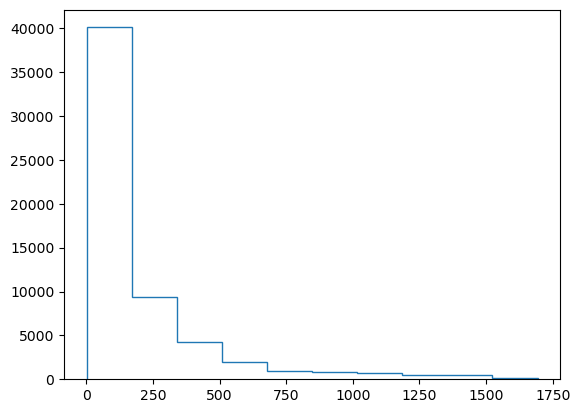

In [15]:
import matplotlib.pyplot as plt

counts, bins = np.histogram(cont_list)
plt.stairs(counts, bins)

In [386]:
thresh =  20

def get_diff(thresh):

    pRemain = (positives["count"] >= thresh).sum()
    nRemain = (dup_df["cont"] >= thresh).sum()

    return pRemain / positives["count"].count(), nRemain / dup_df["cont"].count()


In [351]:
print(f"Total positives lost: {positives.shape[0] - pRemain}")
print(f"Total negatives remaing: {dup_df.shape[0] - (dup_df.shape[0] - nRemain)}")

Total positives lost: 12751
Total negatives remaing: 21


In [19]:
dup_df

,subID,frame,cont,xCenter,yCenter,w,h,conf
0,__20141117_17062,1791,1.0,0.177498,0.794115,0.354996,0.409817,0.906869
1,__20141117_17062,1792,2.0,0.179790,0.814975,0.359581,0.368097,0.908439
2,__20141117_17062,2443,1.0,0.346097,0.294877,0.161710,0.316494,0.960901
3,__20141117_17062,2551,1.0,0.260287,0.761859,0.367764,0.474329,0.906285
4,__20141117_17062,2552,2.0,0.256250,0.774080,0.373150,0.449890,0.909170
...,...,...,...,...,...,...,...,...
322,__20140610_16854,2460,1.0,0.795958,0.328546,0.177837,0.206529,0.916488
323,__20140610_16854,3080,1.0,0.641626,0.493261,0.132759,0.234498,0.909095
324,__20140610_16854,3764,1.0,0.359437,0.774628,0.319634,0.448791,0.939570
325,__20140610_16854,3765,2.0,0.317727,0.779605,0.302759,0.438837,0.906621


In [26]:
dup_df

,subID,frame,cont,xCenter,yCenter,w,h,conf
0,__20141117_17062,1791,1.0,0.177498,0.794115,0.354996,0.409817,0.906869
1,__20141117_17062,1792,2.0,0.179790,0.814975,0.359581,0.368097,0.908439
2,__20141117_17062,2443,1.0,0.346097,0.294877,0.161710,0.316494,0.960901
3,__20141117_17062,2551,1.0,0.260287,0.761859,0.367764,0.474329,0.906285
4,__20141117_17062,2552,2.0,0.256250,0.774080,0.373150,0.449890,0.909170
...,...,...,...,...,...,...,...,...
322,__20140610_16854,2460,1.0,0.795958,0.328546,0.177837,0.206529,0.916488
323,__20140610_16854,3080,1.0,0.641626,0.493261,0.132759,0.234498,0.909095
324,__20140610_16854,3764,1.0,0.359437,0.774628,0.319634,0.448791,0.939570
325,__20140610_16854,3765,2.0,0.317727,0.779605,0.302759,0.438837,0.906621


In [29]:
positives

,index,subID,frame,xCenter,yCenter,w,h,conf
0,16093,__20140331_16579,1,0.499495,0.325169,0.122987,0.210882,0.999322
1,15599,__20140331_16579,2,0.499589,0.324776,0.123739,0.212140,0.999347
2,14316,__20140331_16579,3,0.502490,0.318597,0.123593,0.212977,0.999504
3,15894,__20140331_16579,4,0.504844,0.308963,0.126524,0.213715,0.999434
4,14321,__20140331_16579,5,0.508744,0.298515,0.123706,0.212691,0.999067
...,...,...,...,...,...,...,...,...
59385,17711,__20160123_17766,9306,0.742110,0.213396,0.175463,0.307351,0.999375
59386,16958,__20160123_17766,9307,0.740980,0.190879,0.175937,0.314472,0.999297
59387,18933,__20160123_17766,9308,0.738626,0.176927,0.179664,0.308972,0.999433
59388,17303,__20160123_17766,9309,0.734920,0.159202,0.181003,0.309584,0.999593


In [36]:
print((dup_df["cont"] <= 5).sum())
print(dup_df["cont"].count())
print((positives["cont"] <= 5).sum())
print(positives["cont"].count())

170
327
4456
59390


Text(0.5, 0, 'detection length')

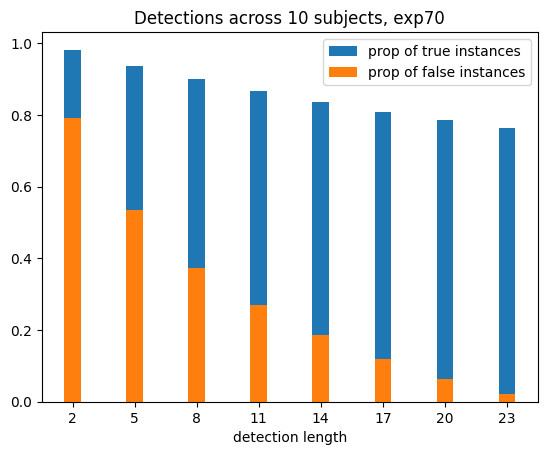

In [417]:
intervals = [i for i in range(2, 26 ,3)]

nRemain = [(dup_df["cont"] >= thresh).sum()/dup_df["cont"].count() for thresh in intervals]
pRemain = [(positives["count"] >= thresh).sum() / positives["count"].count() for thresh in intervals]


fig, ax = plt.subplots()
ax.set_xticks(intervals)

ax.set_title("Detections across 10 subjects, exp70")
ax.bar(intervals, pRemain, label= "prop of true instances")
ax.bar(intervals, nRemain, label= "prop of false instances")
ax.legend()
ax.set_xlabel("detection length")

In [360]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

In [363]:
model = torch.nn.Sequential(
    nn.Linear(4, 6),
    nn.ReLU(),
    nn.Linear(6, 10),
    nn.ReLU(),
    nn.Linear(10, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

In [440]:
from random import sample

sample_sub = int(dup_df.shape[0] / len(bbox_df["subID"].unique()))
sample_idx = []

for subject in bbox_df["subID"].unique():
    temp = bbox_df[bbox_df["subID"] == subject].index
    sample_vals = sample(list(temp), sample_sub)
    
    for val in sample_vals:
        sample_idx.append(val)


In [439]:
train_df = pd.concat(sampleswwwsdw)

320

In [ ]:
for epoch in 10:
    for batch in 
    y_pred = model()
    